In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP
# ==========================================
# Define paths (Using os.getcwd() for notebook compatibility)
BASE_DIR = os.getcwd()
# Default to 2nd_test (4 columns), can be changed to "1st_test/1st_test" (8 columns) etc.
DATA_DIR = os.path.join(BASE_DIR, "2nd_test", "2nd_test")

In [11]:
# ==========================================
# 2. THE MATH (Feature Extraction)
# ==========================================
def load_and_process_data(directory):
    features_list = []
    
    # Get all files and sort them chronologically
    try:
        filenames = sorted([f for f in os.listdir(directory) if not f.startswith('.')])
    except FileNotFoundError:
        print(f"Error: The folder '{directory}' was not found.")
        return pd.DataFrame()

    print(f"Found {len(filenames)} files. Processing data signatures...")

    for filename in filenames:
        filepath = os.path.join(directory, filename)
        
        try:
            # Read the file
            df_raw = pd.read_csv(filepath, sep='\t', header=None)

            # --- KEY FIX: DOWNSAMPLE TO 100 Hz ---
            # Simulate the ESP32's lower sampling rate
            # df_raw = df_raw.iloc[::200, :] 
            
            # --- APPLIED MATH STEP ---
            # 1. RMS
            rms_values = np.sqrt(np.mean(df_raw**2, axis=0))
            # 2. Kurtosis
            kurtosis_values = df_raw.kurtosis(axis=0)
            # 3. Peak
            peak_values = np.max(np.abs(df_raw), axis=0)
            # 4. Crest Factor (Peak / RMS)
            crest_factor_values = peak_values / rms_values
            # 5. Peak-to-Peak (Max - Min)
            p2p_values = np.max(df_raw, axis=0) - np.min(df_raw, axis=0)
            
            row = {'timestamp': filename}
            
            # Save features for all bearings
            num_sensors = df_raw.shape[1]
            for i in range(num_sensors):
                row[f'bearing_{i+1}_rms'] = rms_values[i]
                row[f'bearing_{i+1}_kurtosis'] = kurtosis_values[i]
                row[f'bearing_{i+1}_crest'] = crest_factor_values[i]
                row[f'bearing_{i+1}_p2p'] = p2p_values[i]
            
            features_list.append(row)
            
        except Exception as e:
            continue
            
    return pd.DataFrame(features_list)

In [12]:
# Run the processing
print(f"Loading data from: {DATA_DIR}")
df = load_and_process_data(DATA_DIR)

# Only proceed if data loaded successfully
if not df.empty:
    print(f"Successfully processed {len(df)} time windows.")
    
    # Identify feature columns dynamically (excluding timestamp)
    feature_cols = [c for c in df.columns if c != 'timestamp']
    print(f"Features detected ({len(feature_cols)}): {feature_cols}")
else:
    print("No data found. Please check your DATA_DIR path.")

Loading data from: c:\Users\johne\OneDrive\Documents\GitHub\outliernodemodeltraining\2nd_test\2nd_test
Found 984 files. Processing data signatures...
Successfully processed 984 time windows.
Features detected (16): ['bearing_1_rms', 'bearing_1_kurtosis', 'bearing_1_crest', 'bearing_1_p2p', 'bearing_2_rms', 'bearing_2_kurtosis', 'bearing_2_crest', 'bearing_2_p2p', 'bearing_3_rms', 'bearing_3_kurtosis', 'bearing_3_crest', 'bearing_3_p2p', 'bearing_4_rms', 'bearing_4_kurtosis', 'bearing_4_crest', 'bearing_4_p2p']


In [13]:
# ==========================================
# 3. LABELING (The Applied Math Way)
# ==========================================
if not df.empty:
    # 1. DEFINE A PHYSICAL THRESHOLD
    # Based on your graph, 0.16 is the "Danger Line".
    # Everything below is just normal noise. Everything above is a spike.
    FAILURE_THRESHOLD = 0.16 
    
    # 2. APPLY LABELS
    df['status'] = 0 # Default to Healthy
    
    # If the vibration is louder than the threshold, mark it as 1 (Broken)
    # Note: We use the same bearing we are training on (Bearing 4)
    df.loc[df['bearing_4_rms'] > FAILURE_THRESHOLD, 'status'] = 1 
    
    # 3. SELECT FEATURES (Bearing 4)
    input_features = [
        'bearing_1_rms', 
        'bearing_1_kurtosis', 
        'bearing_1_crest', 
        'bearing_1_p2p'
    ]
    
    X = df[input_features]
    y = df['status']
    
    print(f"Labels assigned based on Threshold > {FAILURE_THRESHOLD}")
    print(f"Healthy Samples: {len(df[df['status']==0])}")
    print(f"Broken Samples:  {len(df[df['status']==1])}")

Labels assigned based on Threshold > 0.16
Healthy Samples: 984
Broken Samples:  0


In [14]:
# ==========================================
# 4. TRAIN RANDOM FOREST
# ==========================================
if not df.empty:
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    # Train Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    print("-" * 30)
    print(f"Model Accuracy (4 Inputs): {accuracy:.2%}")
    print("-" * 30)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print("(Top-Left: True Healthy, Bottom-Right: True Broken)")

------------------------------
Model Accuracy (4 Inputs): 100.00%
------------------------------
Confusion Matrix:
[[197]]
(Top-Left: True Healthy, Bottom-Right: True Broken)


c:\Users\johne\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


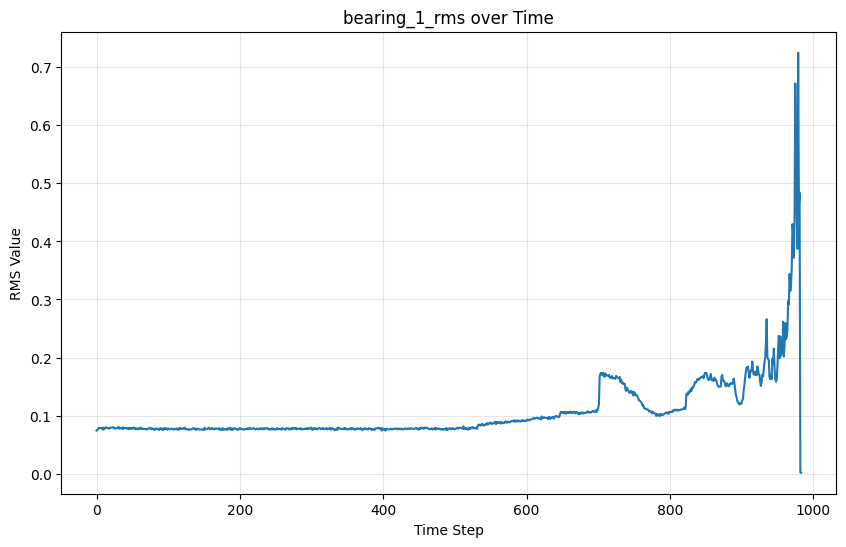

In [15]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    # Plotting the first bearing's RMS as an example
    # Check if 'bearing_1_rms' exists (it differs between 1st_test and 2nd_test datasets)
    col_to_plot = 'bearing_1_rms' if 'bearing_1_rms' in df.columns else feature_cols[0]
    
    plt.plot(df[col_to_plot])
    plt.title(f"{col_to_plot} over Time")
    plt.xlabel("Time Step")
    plt.ylabel("RMS Value")
    plt.grid(True, alpha=0.3)
    plt.show()

Max Safe RMS from Calibration: 0.0810


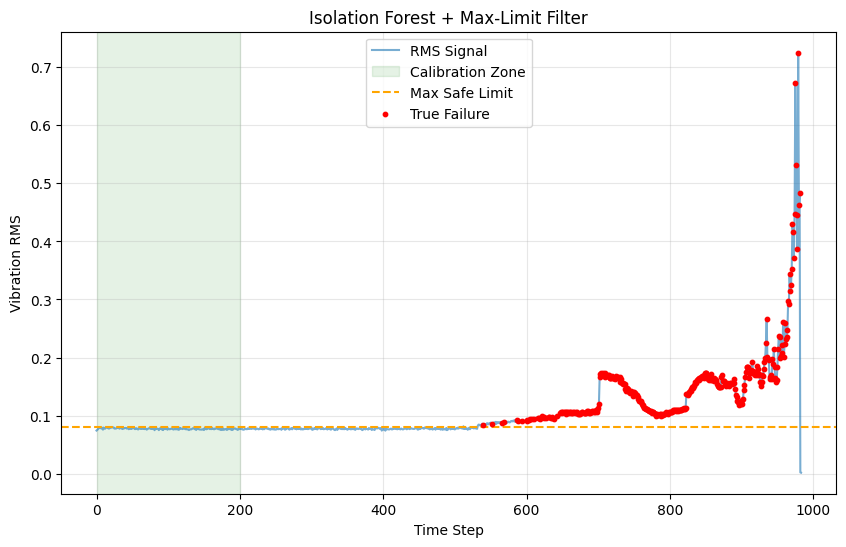

FAILURE DETECTED at Step: 539


In [17]:
from sklearn.ensemble import IsolationForest

# ==========================================
# 2. CALIBRATION (The "Zero False Alarm" Fix)
# ==========================================
if not df.empty:
    # 1. Select Features
    input_features = ['bearing_1_rms', 'bearing_1_p2p']
    X = df[input_features]

    # 2. Define Healthy Zone
    start_cal = 0
    end_cal = 200
    X_train = X.iloc[start_cal:end_cal]

    # --- THE FIX: Use MAX instead of MEAN ---
    # We find the highest vibration the machine survived during calibration.
    # We add a tiny buffer (1%) just to be safe.
    max_safe_rms = X_train['bearing_1_rms'].max() * 1.01
    print(f"Max Safe RMS from Calibration: {max_safe_rms:.4f}")

    # 3. Train Model
    iso_model = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
    iso_model.fit(X_train)

    # 4. CALCULATE THRESHOLD
    train_scores = iso_model.decision_function(X_train)
    anomaly_threshold = np.percentile(train_scores, 1) 

    # 5. MONITORING (Stricter Logic)
    all_scores = iso_model.decision_function(X)
    
    df['smart_status'] = 0
    
    # NEW LOGIC: 
    # Anomaly IF (AI Score is Low) AND (RMS > Max_Safe_RMS)
    condition = (all_scores < anomaly_threshold) & (df['bearing_1_rms'] > max_safe_rms)
    
    df.loc[condition, 'smart_status'] = 1

    # 6. VISUALIZE
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['bearing_1_rms'], label='RMS Signal', alpha=0.6)
    plt.axvspan(start_cal, end_cal, color='green', alpha=0.1, label='Calibration Zone')
    
    # Plot the new "Safety Ceiling" line
    plt.axhline(max_safe_rms, color='orange', linestyle='--', label='Max Safe Limit')

    # Plot Anomalies
    anomalies = df[df['smart_status'] == 1]
    plt.scatter(anomalies.index, anomalies['bearing_1_rms'], color='red', label='True Failure', s=10, zorder=5)

    plt.title("Isolation Forest + Max-Limit Filter")
    plt.xlabel("Time Step")
    plt.ylabel("Vibration RMS")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Diagnostics
    real_alarms = anomalies[anomalies.index > end_cal]
    if not real_alarms.empty:
        print(f"FAILURE DETECTED at Step: {real_alarms.index[0]}")